In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [3]:
df = pd.read_csv("data.csv")

In [4]:
rt_bc = df.loc[df['rxtx'] == True]
bc_rt = df.loc[df['rxtx'] == False]

In [5]:
counts = list(df['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_a = counts.to_frame()

In [6]:
counts = list(rt_bc['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_r = counts.to_frame()

In [7]:
counts = list(bc_rt['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_b = counts.to_frame()

In [9]:
data_b

,value
1959-01-01,10
1959-01-02,5
1959-01-03,25
1959-01-04,2
1959-01-05,9
...,...
1971-12-23,5
1971-12-24,16
1971-12-25,16
1971-12-26,2


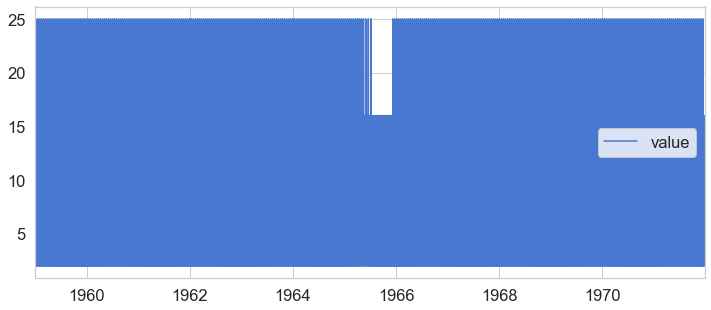

In [8]:
data_b.plot()

### Needs a pattern anomaly Detection. OneClassSVM doesn't work

In [15]:
#OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

outliers_fraction = 0.1

data = data_b[['value']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)

OneClassSVM(gamma=0.01, nu=0.1)

In [16]:
new_df = data_b[['value']]
new_df['anomaly'] = pd.Series(model.predict(data))

#new_df

In [17]:
new_df

,value,anomaly
1959-01-01,10,NaN
1959-01-02,5,NaN
1959-01-03,25,NaN
1959-01-04,2,NaN
1959-01-05,9,NaN
...,...,...
1971-12-23,5,NaN
1971-12-24,16,NaN
1971-12-25,16,NaN
1971-12-26,2,NaN


In [18]:
new_df['anomaly'].value_counts()

Series([], Name: anomaly, dtype: int64)

In [19]:
## Exploring Pattern

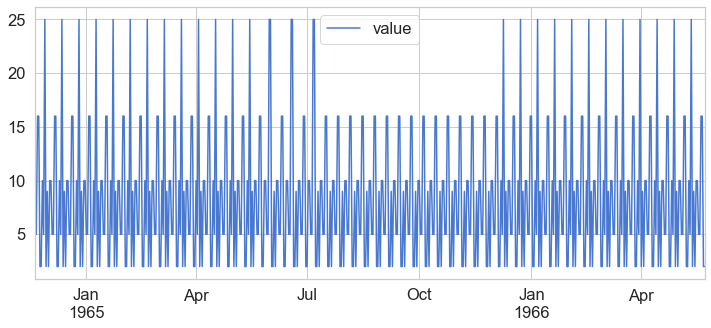

In [20]:
data_b[2150:2700].plot()

In [22]:
data_b[2150:2700]

,value
1964-11-20,5
1964-11-21,5
1964-11-22,16
1964-11-23,16
1964-11-24,2
...,...
1966-05-19,5
1966-05-20,16
1966-05-21,16
1966-05-22,2


# Moving Average Method

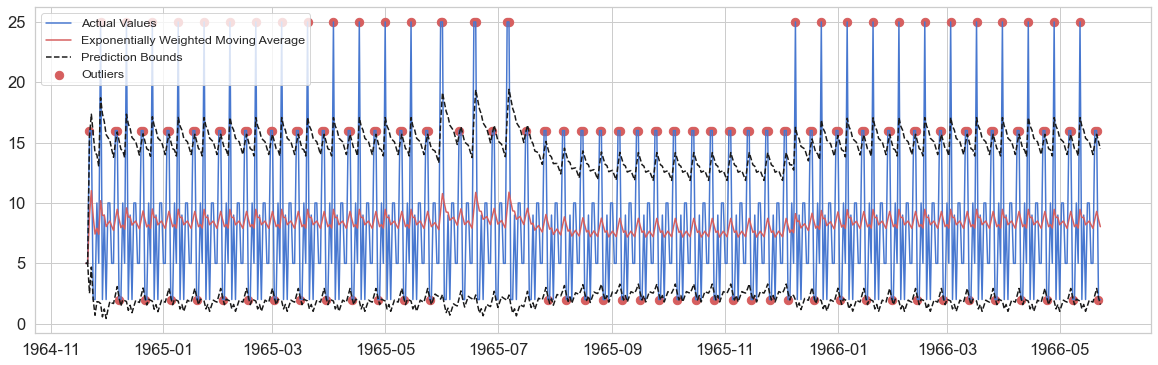

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# exponential weighted (EW) functions.
window_size = 10
mean = data_b[2150:2700]['value'].ewm(window_size).mean()
std = data_b[2150:2700]['value'].ewm(window_size).std()
std[0] = 0 #the first value turns into NaN because of no data

mean_plus_std = mean + std
mean_minus_std = mean - std

is_outlier = (data_b[2150:2700]['value'] > mean_plus_std) | (data_b[2150:2700]['value'] < mean_minus_std)
outliers = data_b[2150:2700][is_outlier]

plt.figure(figsize=(20,6))
plt.plot(data_b[2150:2700]['value'], c = 'b', label = 'Actual Values')
plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
plt.plot(mean_minus_std, 'k--')
plt.scatter(outliers.index, outliers['value'], c = 'r', marker = 'o', s = 70, label = 'Outliers')
plt.legend(loc='upper left',fontsize ='x-small')
#plt.legend()

### Needs a pattern Detection Method

## LSTM

In [44]:
# LSTM Autoencoder Model 
def create_model(learning_rate):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
      keras.layers.TimeDistributed(
        keras.layers.Dense(units=X_train.shape[2])
      )
    )

    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.8)

    # Loss used in the guide is MAE. RMSE would penalize large errors more. Possible future research.
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [45]:
train = data_b[:2149] 
test = data_b[2150:2700]

In [46]:
len(test)

550

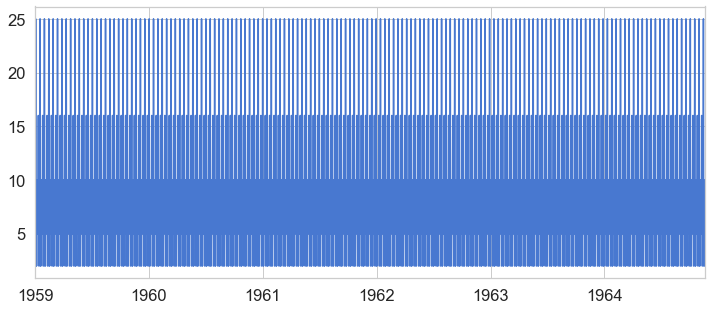

In [47]:
train['value'].plot()

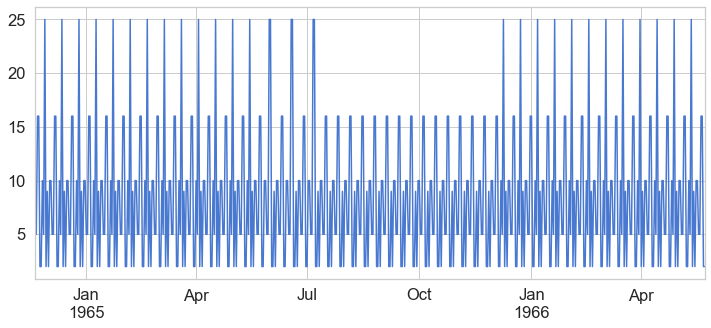

In [48]:
test['value'].plot()

In [49]:
# Helper function to create windows of data of length `time_steps`
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [50]:
# Standarize the `value` column
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [51]:
test

,value
1964-11-20,-0.535781
1964-11-21,-0.535781
1964-11-22,1.147320
1964-11-23,1.147320
1964-11-24,-0.994809
...,...
1966-05-19,-0.535781
1966-05-20,1.147320
1966-05-21,1.147320
1966-05-22,-0.994809


In [52]:
TIME_STEPS = 3

# Use the helper function to reshape the data to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
                                      train[['value']],
                                      train.value,
                                      TIME_STEPS
                                 )

X_test, y_test = create_dataset(
                                    test[['value']],
                                    test.value,
                                    TIME_STEPS
                               )

print(X_train.shape)

(2146, 3, 1)


In [53]:
X_test.shape

(547, 3, 1)

In [54]:
# reshape input to be [samples, time steps, features]   :batch-major[batch, timesteps, feature],  (not time_major[timesteps, batch, feature])
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
"""
time_major: 
    The shape format of the inputs and outputs tensors. 
    
    If True, the inputs and outputs will 
    be in shape [timesteps, batch, feature], whereas  :time_major
    
    in the False case, it will be [batch, timesteps, feature].  :batch-major 
    
    Using time_major = True is a bit more efficient because it avoids transposes 
    at the beginning and end of the RNN calculation. However, most TensorFlow data is 
    batch-major, so by default this function accepts input and emits output in batch-major form.
"""

In [55]:
print(X_train.shape)

(2146, 1, 3)


In [57]:
print(X_test.shape)

(547, 1, 3)


In [64]:
X_train_pred.shape

(2146, 1, 3)

In [65]:
X_test_pred.shape

(547, 1, 3)

In [58]:
LEARNING_RATE = .01
model = create_model(LEARNING_RATE)
history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,
    )


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1931 samples, validate on 215 samples
Epoch 1/100
1931/1931 [==============================] - 1s 642us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 2/100
1931/1931 [==============================] - 0s 93us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 3/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 4/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 5/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 6/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 7/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 8/100
1931/1931 [============

1931/1931 [==============================] - 0s 92us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 71/100
1931/1931 [==============================] - 0s 89us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 72/100
1931/1931 [==============================] - 0s 84us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 73/100
1931/1931 [==============================] - 0s 89us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 74/100
1931/1931 [==============================] - 0s 91us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 75/100
1931/1931 [==============================] - 0s 86us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 76/100
1931/1931 [==============================] - 0s 94us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 77/100
1931/1931 [==============================] - 0s 87us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 78/100
1931/1931 [==============================] - 0s 85us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 79/100
1931/1931 [==========================

In [59]:
# Save/Load Model to/from Disk

model_json = model.to_json()
with open("model.02.json", "w") as json_file:
    json_file.write(model_json)
# Serialize network weights to HDF5
model.save_weights("model.02.h5")
print("Saved model to disk")

# Saved model to disk
with open("model.02.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = keras.models.model_from_json(loaded_model_json)


# load weights into new model
loaded_model.load_weights("model.02.h5")
print("Loaded model from disk")
#Loaded model from disk
print(f"Saved model matches trained model: {model.get_config() == loaded_model.get_config()}")
#Saved model matches trained model: True

Saved model to disk
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk
Saved model matches trained model: True


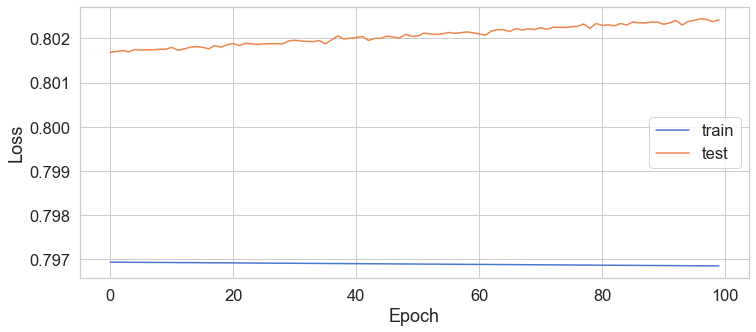

In [60]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

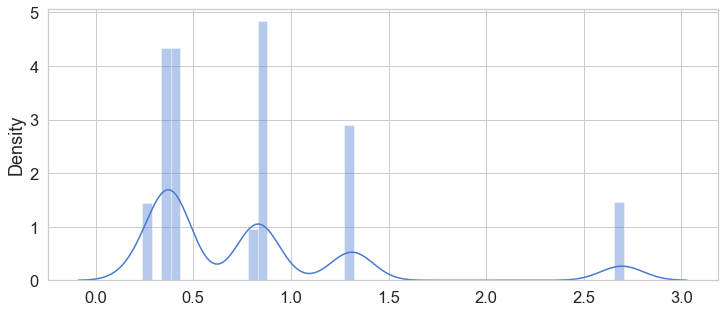

In [61]:
# Prediction

X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True);

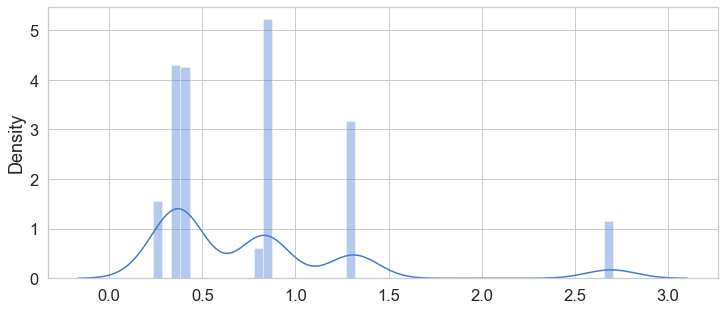

In [62]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True)

In [63]:
X_test_pred.shape

(547, 1, 3)

In [66]:
len(X_test_pred)

547

In [95]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])


In [96]:
test_predict.shape

(547, 1, 3)

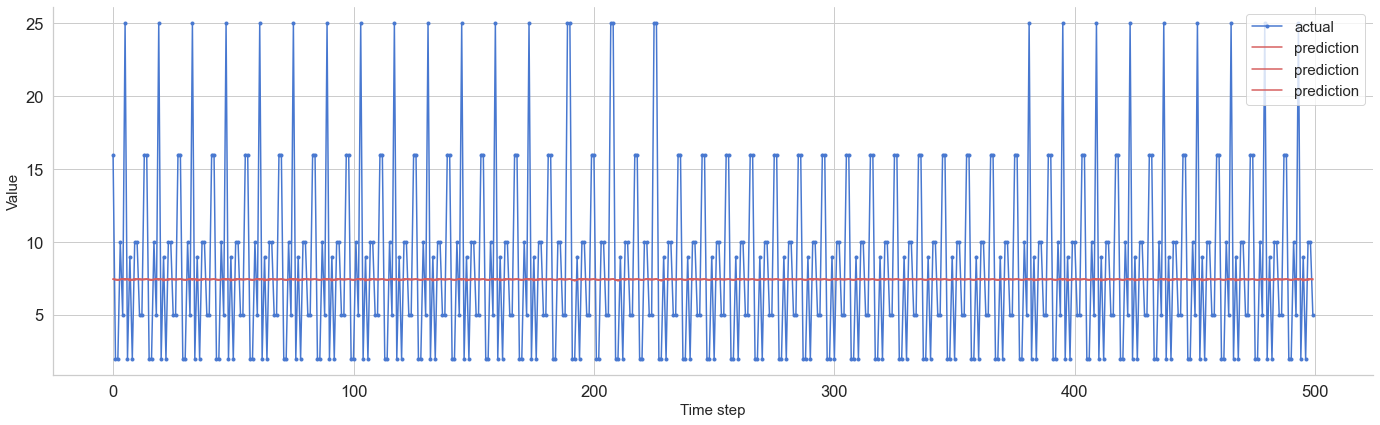

In [106]:

aa=[x for x in range(500)]
plt.figure(figsize=(20,6))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [104]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
## Prediction
scalar2 = MinMaxScaler(feature_range=(-1, 25))
#predict_y = scaler(predict_y)

scalar2.fit(test_predict.reshape(547, 3))
test_predict2 = scalar2.transform(test_predict.reshape(547, 3))

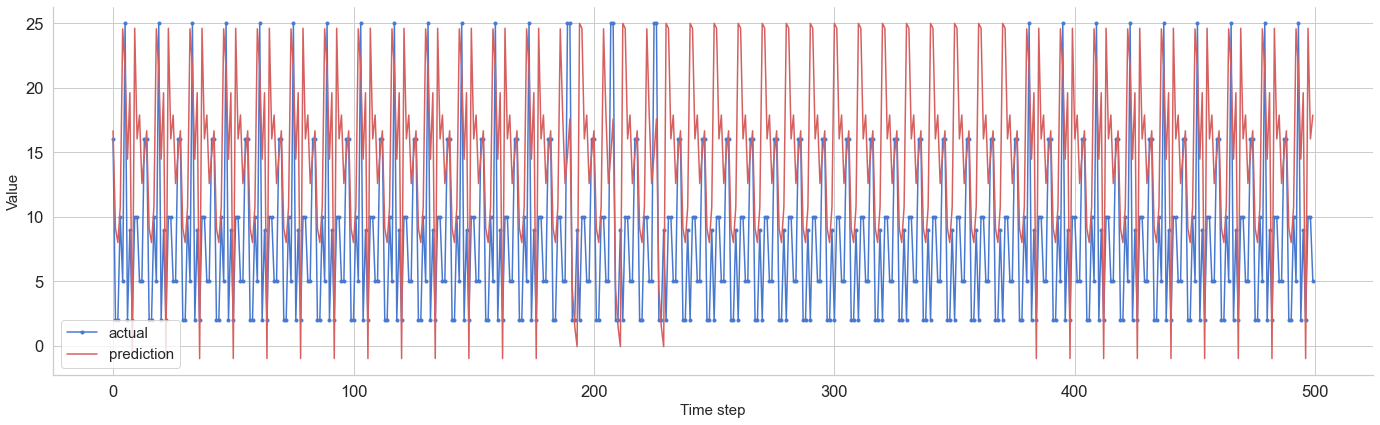

In [107]:

aa=[x for x in range(500)]
plt.figure(figsize=(20,6))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict2[:,0][:500], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Value', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [180]:
THRESHOLD =7.5

In [181]:
TIME_STEPS

3

In [182]:
#test_predict2
test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)

In [183]:
test_score_df

""
1964-11-23
1964-11-24
1964-11-25
1964-11-26
1964-11-27
...
1966-05-19
1966-05-20
1966-05-21
1966-05-22


In [184]:
X_test2 = X_test.reshape(547, 3)

In [185]:
test_mae_loss = np.mean(np.abs(test_predict2 - X_test2), axis=1)

In [186]:
test_mae_loss.shape

(547,)

In [187]:
test_mae_loss2 = test_predict2[:,0][:547] - X_test2[:,0][:547]

In [188]:
test_mae_loss2.shape

(547,)

In [189]:
test_score_df['loss'] = test_mae_loss

In [190]:
test_score_df[200:400]

,loss
1965-06-11,20.026058
1965-06-12,12.924090
1965-06-13,9.092032
1965-06-14,14.863937
1965-06-15,23.981031
...,...
1965-12-23,18.973407
1965-12-24,17.857995
1965-12-25,14.049947
1965-12-26,11.696073


In [191]:
test_score_df[290:310]

,loss
1965-09-09,23.961355
1965-09-10,19.895071
1965-09-11,19.160020
1965-09-12,18.543669
1965-09-13,14.214065
1965-09-14,16.799809
1965-09-15,20.026058
1965-09-16,12.924090
1965-09-17,9.092032
1965-09-18,14.863937


In [192]:
test_score_df['threshold'] = THRESHOLD

In [196]:
test_score_df['anomaly'] = test_score_df.loss < test_score_df.threshold

In [197]:
test_score_df

,loss,threshold,anomaly
1964-11-23,20.026058,7.5,False
1964-11-24,12.924090,7.5,False
1964-11-25,9.092032,7.5,False
1964-11-26,14.863937,7.5,False
1964-11-27,23.981031,7.5,False
...,...,...,...
1966-05-19,14.214065,7.5,False
1966-05-20,16.799809,7.5,False
1966-05-21,20.026058,7.5,False
1966-05-22,12.924090,7.5,False


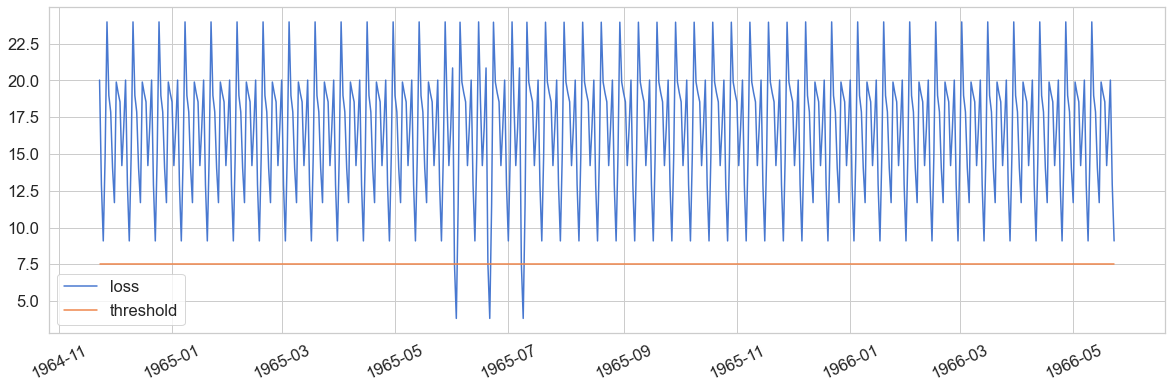

In [198]:
plt.figure(figsize=(20,6))
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

In [44]:
#test_predict2
test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['anomaly'] = test_score_df.loss < test_score_df.threshold
test_score_df['value'] = test.iloc[TIME_STEPS:].value

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

ValueError: Wrong number of items passed 30, placement implies 1

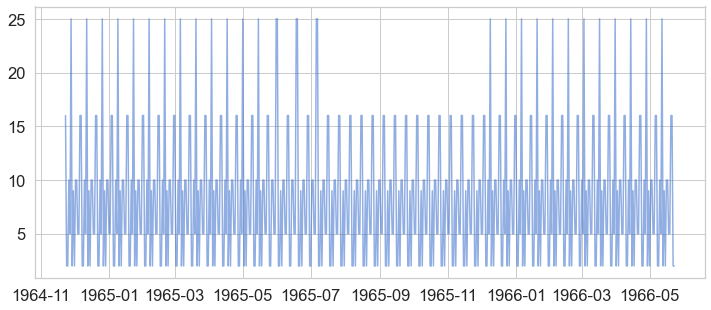

In [70]:
plt.plot(
    test.value.iloc[TIME_STEPS:].index, 
    scaler.inverse_transform(test.iloc[TIME_STEPS:].value),
    alpha=0.6
)
